# Delta Stacking Shift Map for a Triangular Moiré Twisted Bilayer (1°)

The construction follows the linear registry map
$$
\mathbf{s}(\mathbf{r}) = (R_\theta - I)\,\mathbf{r} + \boldsymbol{\tau} \quad \mathrm{mod}\ \mathcal{L},
$$
where $R_\theta$ is the in-plane rotation by angle $\theta$, $I$ the identity, $\boldsymbol{\tau}$ the stacking gauge, and $\mathcal{L}$ the monolayer Bravais lattice.

The **moiré Bravais basis** $\{\mathbf{a}_1^M,\mathbf{a}_2^M\}$ is defined by the requirement that $\mathbf{s}(\mathbf{r}+\mathbf{a}_i^{M}) \equiv \mathbf{s}(\mathbf{r})\ (\mathrm{mod}\ \mathcal{L})$, which yields
$$
\boxed{\quad \mathbf{a}_i^{M} = (R_\theta - I)^{-1} \mathbf{a}_i,\quad i=1,2. \quad}
$$

The inverse map needed to place a given registry shift $\mathbf{s}$ into the moiré cell is
$$
\boxed{\quad \mathbf{r}(\mathbf{s}) = (R_\theta - I)^{-1}\,(\mathbf{s}-\boldsymbol{\tau})\quad \mathrm{mod}\ \mathcal{L}_M, \quad}
$$
where $\mathcal{L}_M$ is the moiré lattice spanned by $\{\mathbf{a}_1^{M},\mathbf{a}_2^{M}\}$.

## Triangular Bravais Lattice and Reciprocal Lattice

Real-space basis
$$
\mathbf{a}_1 = a(1,0),\qquad \mathbf{a}_2 = a\left(\tfrac12,\tfrac{\sqrt{3}}{2}\right),
$$
and stack them as columns $A=[\mathbf{a}_1,\mathbf{a}_2]$. The reciprocal basis $B=[\mathbf{b}_1,\mathbf{b}_2]$ satisfies $\mathbf{b}_i\cdot\mathbf{a}_j = 2\pi\delta_{ij}$, i.e.
$$
B = 2\pi\,(A^{-1})^{\!\top}.
$$

A small twist by angle $\theta$ produces the linear map
$$
\mathbf{s}(\mathbf{r}) = M\,\mathbf{r} + \boldsymbol{\tau},\qquad M \equiv R_\theta - I.
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def rot(theta: float) -> np.ndarray:
    """Return 2x2 rotation matrix for angle theta (radians)."""
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s,  c]])

def fractional_reduce(vec: np.ndarray, A: np.ndarray) -> np.ndarray:
    """
    Reduce 'vec' into the unit cell spanned by columns of A via fractional coords in [0,1).
    """
    f = np.linalg.solve(A, vec) % 1.0
    return A @ f

def reciprocal_from_real(A: np.ndarray) -> np.ndarray:
    """Return reciprocal basis B with b_i · a_j = 2π δ_ij."""
    return 2 * np.pi * np.linalg.inv(A).T

def parallelogram_corners(A: np.ndarray) -> np.ndarray:
    """Four corners of the unit cell polygon from A=[a1,a2]."""
    o = np.zeros(2); a1 = A[:,0]; a2 = A[:,1]
    return np.array([o, a1, a1 + a2, a2])

def moire_bases_and_maps(A: np.ndarray, theta: float, tau: np.ndarray = None):
    """Compute M, A_M, B, G_to_GM, tau for the registry map s(r) = (R - I) r + tau."""
    if tau is None: tau = np.zeros(2)
    R = rot(theta)
    M = R - np.eye(2)
    A_M = np.linalg.solve(M, A)      # (R-I) A_M = A
    B   = reciprocal_from_real(A)
    G_to_GM = M.T
    return M, A_M, B, G_to_GM, tau

def s_of_r(r: np.ndarray, M: np.ndarray, tau: np.ndarray, A: np.ndarray) -> np.ndarray:
    """Return s reduced mod A: s = M r + tau (mod L)."""
    return fractional_reduce(M @ r + tau, A)

def r_of_s(s: np.ndarray, M: np.ndarray, tau: np.ndarray, A_M: np.ndarray) -> np.ndarray:
    """Return r reduced mod A_M: r = M^{-1} (s - tau) (mod L_M)."""
    return fractional_reduce(np.linalg.solve(M, (s - tau)), A_M)

## Periodic Scalar on the Shift Torus

To color points periodically over the shift torus, use a first-star Fourier ansatz
$$
f(\mathbf{s}) = \cos(\mathbf{b}_1\!\cdot\!\mathbf{s}) + \cos(\mathbf{b}_2\!\cdot\!\mathbf{s}) + \cos((\!-\mathbf{b}_1\!-\mathbf{b}_2)\!\cdot\!\mathbf{s}),
$$
which is manifestly periodic on $\mathbb{R}^2/\mathcal{L}$. 

In [2]:
# Triangular real-space basis
a = 1.0
a1 = np.array([a, 0.0])
a2 = np.array([0.5*a, np.sqrt(3)/2*a])
A  = np.column_stack([a1, a2])

# Twist angle and gauge
theta_deg = 1.0
theta = np.deg2rad(theta_deg)
tau = np.zeros(2)

# Build maps
M, A_M, B, G_to_GM, tau = moire_bases_and_maps(A, theta, tau=tau)

# First-star reciprocal vectors for the periodic scalar
b1 = B[:,0]; b2 = B[:,1]; b3 = -(b1 + b2)

def periodic_scalar_on_shift(s: np.ndarray) -> float:
    return np.cos(b1 @ s) + np.cos(b2 @ s) + np.cos(b3 @ s)

## Build the 20×20 Grid on the Shift Torus and Map It into the Moiré Cell

Points are sampled cell-centered in fractional coordinates $(u,v)\in[0,1)$ to avoid boundary degeneracies. They are then mapped by
$$
\mathbf{r} = (R_\theta - I)^{-1}(\mathbf{s}-\boldsymbol{\tau}) \quad (\mathrm{mod}\ \mathcal{L}_M).
$$

In [3]:
N = 20
us = (np.arange(N) + 0.5) / N
vs = (np.arange(N) + 0.5) / N

S_points = []
R_points = []
colors = []  # legacy scalar colors (first-star Fourier)

for u in us:
    for v in vs:
        s = A @ np.array([u, v])
        s = fractional_reduce(s, A)
        S_points.append(s)
        r = r_of_s(s, M, tau, A_M)
        R_points.append(r)
        colors.append(periodic_scalar_on_shift(s))

S_points = np.array(S_points)
R_points = np.array(R_points)
colors = np.array(colors)

# New: dual-direction torus coloring via two independent 1D colormaps blended
# Obtain fractional coordinates (u,v) in [0,1) for each shift point
frac_coords = np.linalg.solve(A, S_points.T) % 1.0  # shape (2, n)
u_coords, v_coords = frac_coords

import matplotlib.cm as cm
cmap_u = cm.get_cmap('Reds')    # color evolution along a1 direction
cmap_v = cm.get_cmap('Blues')   # color evolution along a2 direction

def blend_rgb(c1, c2, mode='screen'):
    a = np.array(c1[:3])
    b = np.array(c2[:3])
    if mode == 'multiply':
        rgb = np.sqrt(a * b)
    elif mode == 'average':
        rgb = 0.5 * (a + b)
    else:  # screen (default) keeps brightness and separates corners
        rgb = 1 - (1 - a) * (1 - b)
    return np.clip(rgb, 0, 1)

colors_uv = np.array([blend_rgb(cmap_u(u), cmap_v(v), mode='screen') for u, v in zip(u_coords, v_coords)])

/tmp/ipykernel_28745/285426481.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_u = cm.get_cmap('Reds')    # color evolution along a1 direction
/tmp/ipykernel_28745/285426481.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_v = cm.get_cmap('Blues')   # color evolution along a2 direction


## Visualization

Left: monolayer unit cell (shift torus) with a schematic 2-atom basis (one atom at the origin, the other at a representative shift).  
Right: moiré unit cell with mapped points (same colors).

### Dual-Colormap Torus Coloring
The monolayer (shift) torus is periodic in two independent fractional directions (along $\mathbf{a}_1$ and $\mathbf{a}_2$). A single scalar colormap forces equivalent colors at opposite edges, obscuring directional phase information. We therefore:
1. Extract fractional coordinates $(u,v) \in [0,1)^2$ for each shift point.
2. Map $u$ through a 1D colormap (Reds) and $v$ through a second (Blues).
3. Blend the two RGB triples with a screen compositing rule: $c = 1-(1-c_u)(1-c_v)$.
This produces a unique hue for each point while still identifying opposite edges (they match only when both $u$ and $v$ match modulo 1). The same blended colors are used on the moiré shift torus (mapped domain).

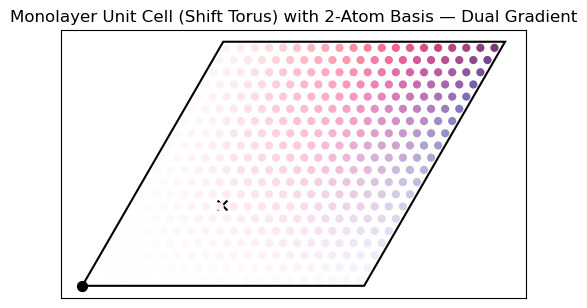

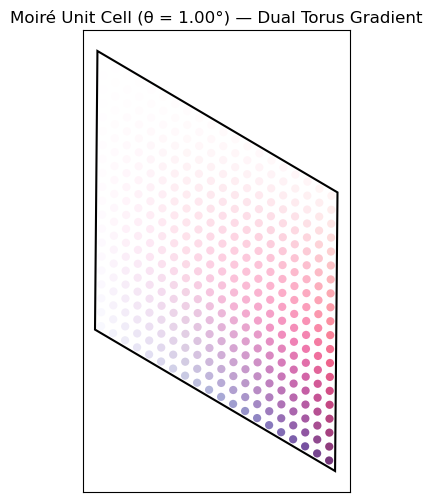

In [4]:
# Figure 1: Shift torus with 2-atom schematic and periodic 20x20 dots
fig1 = plt.figure(figsize=(6,6))
ax1 = fig1.add_subplot(111)
ax1.set_aspect("equal", adjustable="box")

# Monolayer unit cell polygon
poly_S = Polygon(parallelogram_corners(A), fill=False, linewidth=1.5)
ax1.add_patch(poly_S)

# Schematic 2-atom basis: base atom at origin, probe at an example shift
base_atom = np.zeros(2)
probe_shift_example = fractional_reduce(A @ np.array([0.33, 0.33]), A)
ax1.scatter([base_atom[0]], [base_atom[1]], s=50, marker='o', c='k')
ax1.scatter([probe_shift_example[0]], [probe_shift_example[1]], s=50, marker='x', c='k')

# Periodic dot map using blended dual-direction colors
ax1.scatter(S_points[:,0], S_points[:,1], c=colors_uv, s=35, edgecolors='none')

ax1.set_title("Monolayer Unit Cell (Shift Torus) with 2-Atom Basis — Dual Gradient")
ax1.set_xticks([]); ax1.set_yticks([])
plt.show()

# Figure 2: Moiré unit cell with mapped dots (same dual colors)
fig2 = plt.figure(figsize=(6,6))
ax2 = fig2.add_subplot(111)
ax2.set_aspect("equal", adjustable="box")

poly_R = Polygon(parallelogram_corners(A_M), fill=False, linewidth=1.5)
ax2.add_patch(poly_R)

ax2.scatter(R_points[:,0], R_points[:,1], c=colors_uv, s=35, edgecolors='none')

ax2.set_title(f"Moiré Unit Cell (θ = {theta_deg:.2f}°) — Dual Torus Gradient")
ax2.set_xticks([]); ax2.set_yticks([])
plt.show()

## Geometry Diagnostics

In [5]:
a_mag   = np.linalg.norm(A[:,0])
L_M_mag = np.linalg.norm(A_M[:,0])
area_ratio = abs(np.linalg.det(A_M)) / abs(np.linalg.det(A))

print("Monolayer |a1| =", a_mag)
print("Moiré     |a1^M| =", L_M_mag)
print("Area ratio A_M / A =", area_ratio)

Monolayer |a1| = 1.0
Moiré     |a1^M| = 57.296506740065155
Area ratio A_M / A = 3282.8896846143307


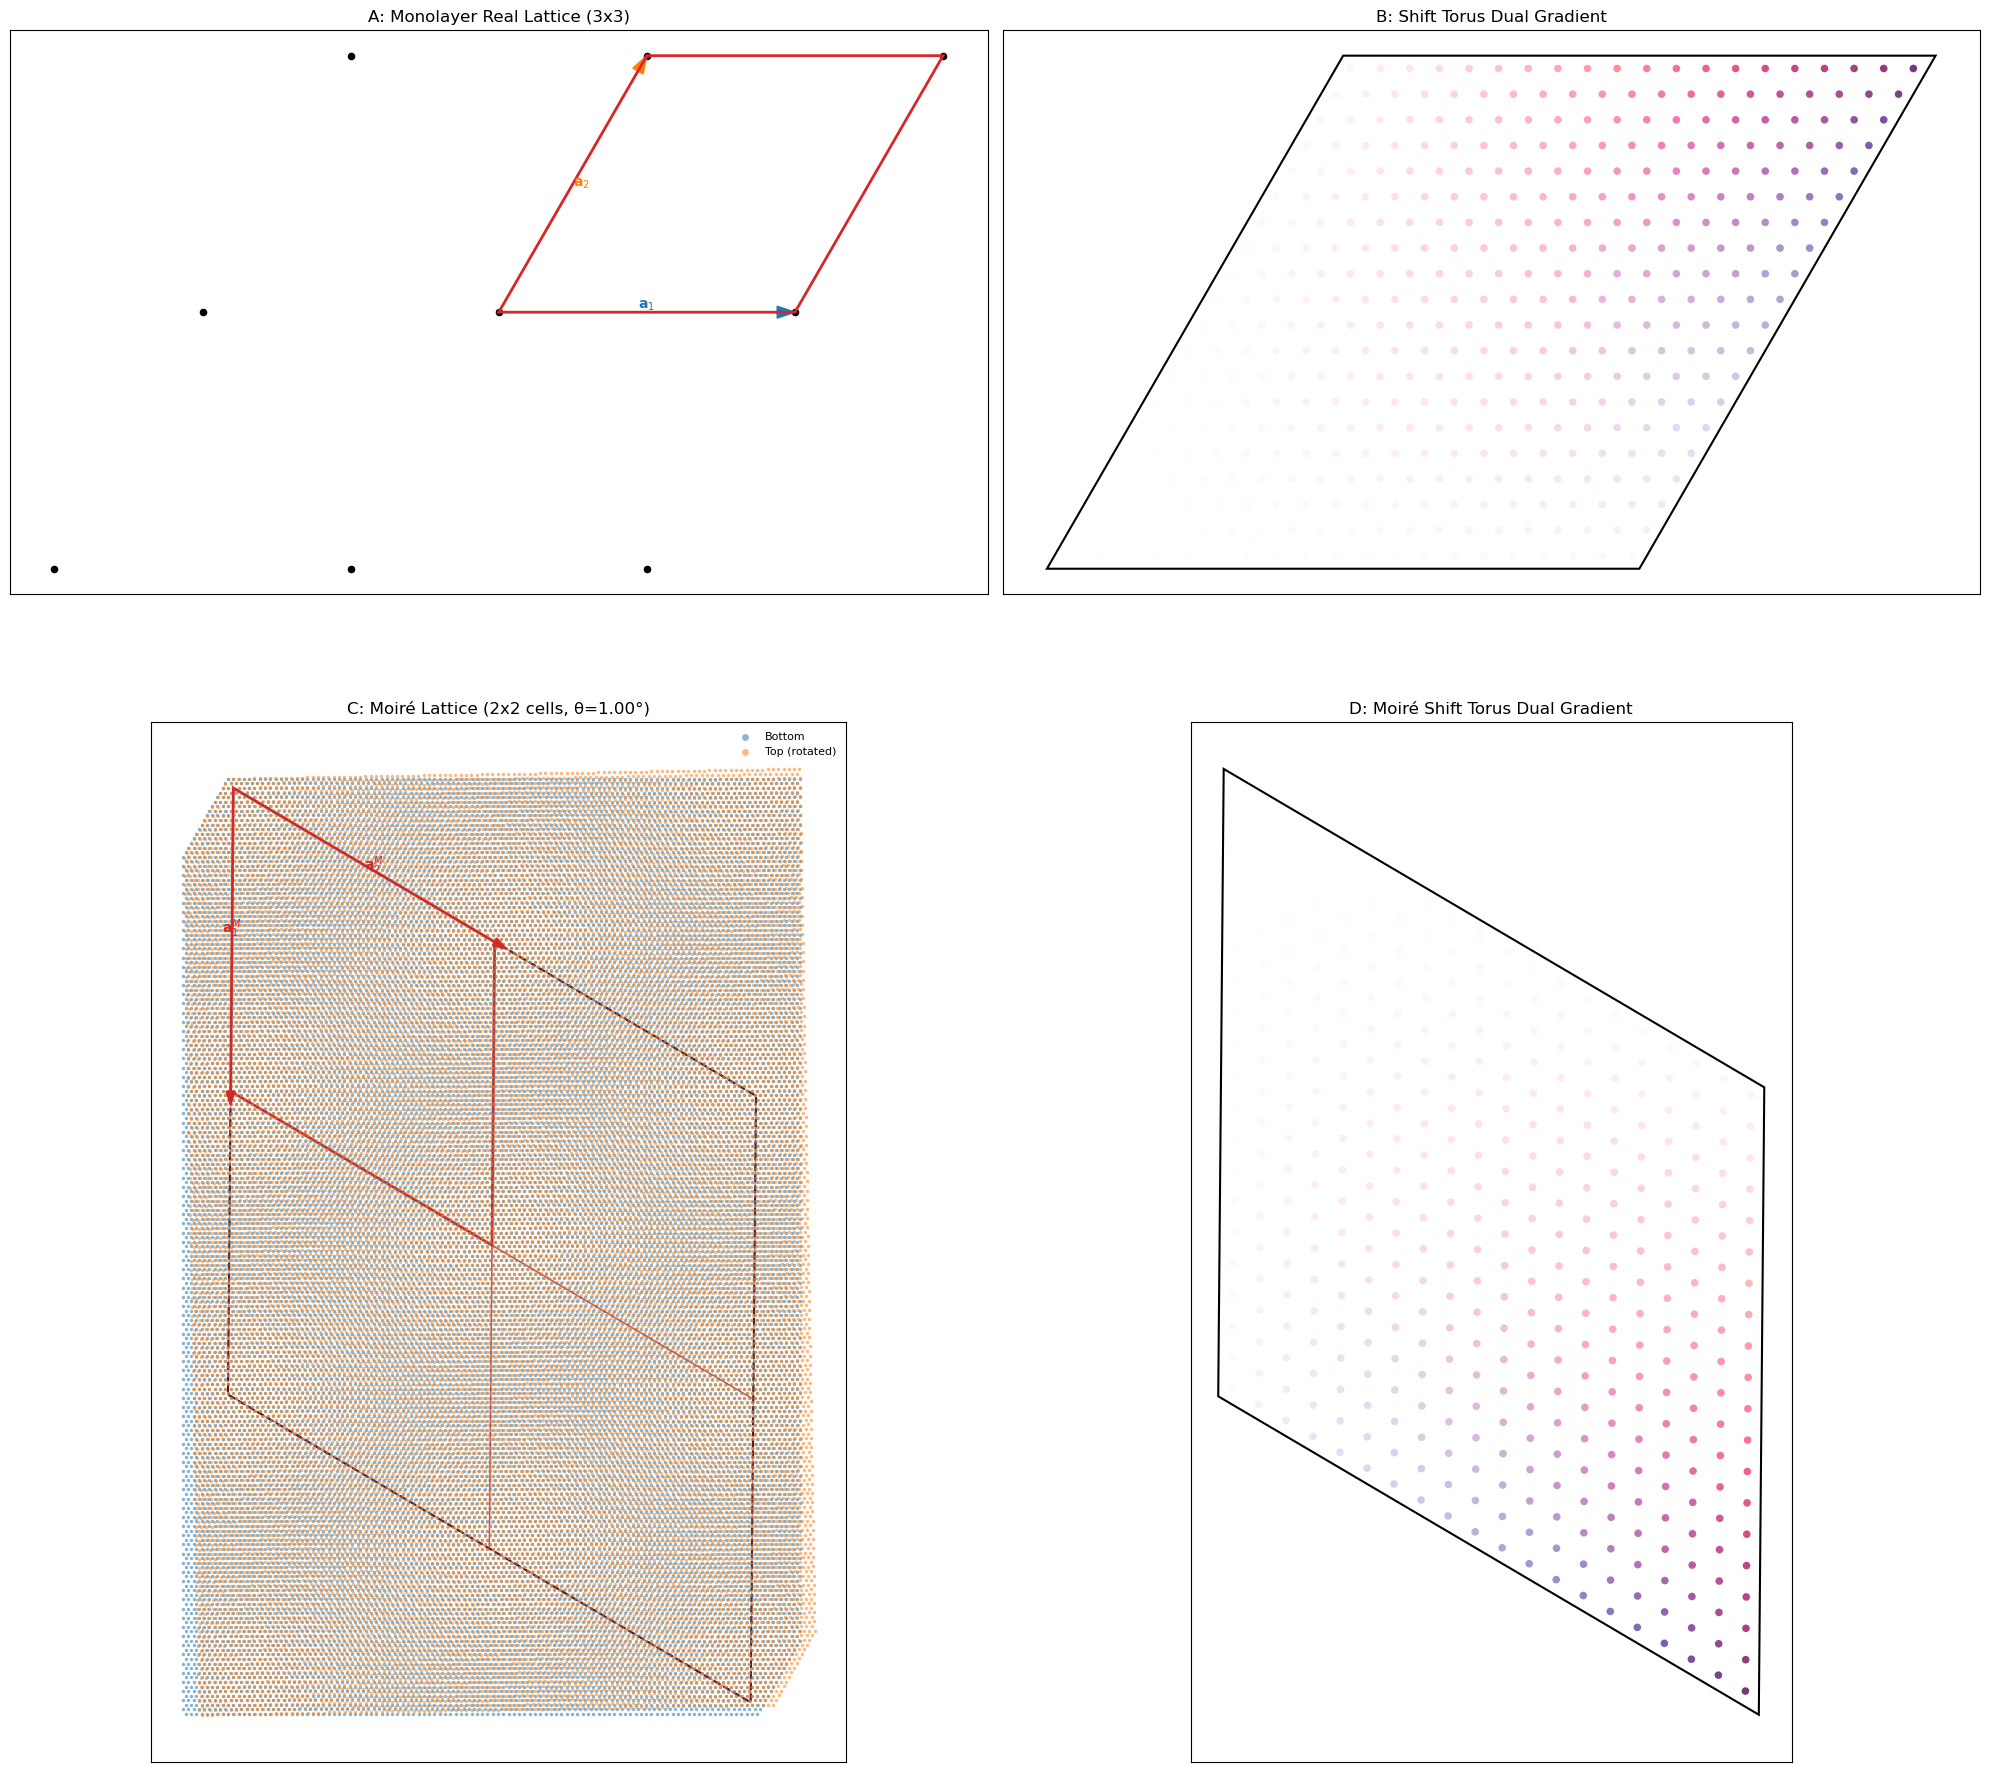

In [6]:
# Composite 2x2 mosaic: 
# A: Monolayer real lattice (3x3 cells)
# B: Shift torus (monolayer unit cell dual-gradient)
# C: Moiré lattice (2x2 moiré cells) with both layers to show pattern
# D: Moiré shift torus (moire unit cell dual-gradient)

fig, axes = plt.subplots(2, 2, figsize=(20, 20))
(axA, axB), (axC, axD) = axes

############################################
# Panel A: Monolayer real-space lattice 3x3
############################################
rng = range(-1, 2)
pts = []
for i in rng:
    for j in rng:
        pts.append(i * a1 + j * a2)
pts = np.array(pts)
axA.scatter(pts[:,0], pts[:,1], c='k', s=20)
axA.arrow(0, 0, a1[0], a1[1], head_width=0.04*a, length_includes_head=True, fc='C0', ec='C0')
axA.arrow(0, 0, a2[0], a2[1], head_width=0.04*a, length_includes_head=True, fc='C1', ec='C1')
cell_poly = Polygon(parallelogram_corners(A), closed=True, fill=False, lw=2, ec='C3')
axA.add_patch(cell_poly)
axA.text(*(a1*0.5), r"$\mathbf{a}_1$", color='C0', ha='center', va='bottom')
axA.text(*(a2*0.5), r"$\mathbf{a}_2$", color='C1', ha='left', va='center')
axA.set_title('A: Monolayer Real Lattice (3x3)')
axA.set_aspect('equal')
axA.set_xticks([]); axA.set_yticks([])

############################################
# Panel B: Shift torus dual-direction gradient
############################################
poly_S = Polygon(parallelogram_corners(A), fill=False, linewidth=1.5)
axB.add_patch(poly_S)
axB.scatter(S_points[:,0], S_points[:,1], c=colors_uv, s=30, edgecolors='none')
axB.set_title('B: Shift Torus Dual Gradient')
axB.set_aspect('equal')
axB.set_xticks([]); axB.set_yticks([])

############################################
# Panel C: Moiré lattice (2x2) both layers
############################################
Rmat = rot(theta)
m1, m2 = A_M[:,0], A_M[:,1]
moire_super_basis = np.column_stack([2*m1, 2*m2])
corners_super = parallelogram_corners(moire_super_basis)
A_inv = np.linalg.inv(A)
frac_corners = (A_inv @ corners_super.T).T
pad = 2
u_min = int(np.floor(frac_corners[:,0].min()) - pad)
u_max = int(np.ceil (frac_corners[:,0].max()) + pad)
v_min = int(np.floor(frac_corners[:,1].min()) - pad)
v_max = int(np.ceil (frac_corners[:,1].max()) + pad)
margin = 0.15 * np.linalg.norm(m1)
mins = corners_super.min(axis=0) - margin
maxs = corners_super.max(axis=0) + margin
bottom_pts = []
for i in range(u_min, u_max+1):
    for j in range(v_min, v_max+1):
        r = i * a1 + j * a2
        if (mins[0] <= r[0] <= maxs[0]) and (mins[1] <= r[1] <= maxs[1]):
            bottom_pts.append(r)
bottom_pts = np.array(bottom_pts)
top_pts = (Rmat @ bottom_pts.T).T
poly_moire_super = Polygon(parallelogram_corners(moire_super_basis), fill=False, lw=1.5, ec='k', ls='--')
axC.add_patch(poly_moire_super)
poly_moire_cell = Polygon(parallelogram_corners(A_M), fill=False, lw=2, ec='C3')
axC.add_patch(poly_moire_cell)
for I in [0,1]:
    for J in [0,1]:
        if I == 0 and J == 0: continue
        shift_cell = I*m1 + J*m2
        poly = Polygon(parallelogram_corners(A_M) + shift_cell, fill=False, lw=1, ec='C3', alpha=0.6)
        axC.add_patch(poly)
axC.scatter(bottom_pts[:,0], bottom_pts[:,1], s=6, c='tab:blue', alpha=0.55, linewidths=0, label='Bottom')
axC.scatter(top_pts[:,0],    top_pts[:,1],    s=6, c='tab:orange', alpha=0.55, linewidths=0, label='Top (rotated)')
axC.arrow(0, 0, m1[0], m1[1], head_width=0.03*np.linalg.norm(m1), ec='C3', fc='C3')
axC.arrow(0, 0, m2[0], m2[1], head_width=0.03*np.linalg.norm(m2), ec='C3', fc='C3')
axC.text(*(0.5*m1), r"$\mathbf{a}_1^{M}$", color='C3', ha='center', va='bottom')
axC.text(*(0.5*m2), r"$\mathbf{a}_2^{M}$", color='C3', ha='left', va='center')
axC.set_title(f'C: Moiré Lattice (2x2 cells, θ={theta_deg:.2f}°)')
axC.set_aspect('equal')
axC.set_xticks([]); axC.set_yticks([])
axC.legend(loc='upper right', fontsize=8, frameon=False, markerscale=2)

############################################
# Panel D: Moiré shift torus dual-direction gradient
############################################
poly_R = Polygon(parallelogram_corners(A_M), fill=False, linewidth=1.5)
axD.add_patch(poly_R)
axD.scatter(R_points[:,0], R_points[:,1], c=colors_uv, s=30, edgecolors='none')
axD.set_title('D: Moiré Shift Torus Dual Gradient')
axD.set_aspect('equal')
axD.set_xticks([]); axD.set_yticks([])

plt.tight_layout()
plt.show()